# Rozpoznawanie symboli matematycznych - Inteligencja obliczeniowa Projekt 2
**Autor:** *Paweł Olszewski*

## Wstęp

Poniższa praca opisuje moje implementacje sieci neuronowych których zadaniemjest rozpoznawanie liczb oraz ośmiu symboli matematycznych (" + ", " - ", " * ", " / ", " = ", " . ", " x ", " y ") z obrazów. W dalszej części pracy omówię pięć modeli sieci neuronowych.

# 1. Przygotowanie danych treningowych i testowych

Baza danych pochodzi ze strony [kaggle](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols). Wszystkie obrazy miały różne rozmiary i niejednolite nazwy (np. "0CdBlhLw.png"). Po zmaiane rozmiarów wszystkich obrazów na **40px**, podzieliłem je na zbiory treningowe i testowe o proporcjach **80%/20%**, a następnie zapisałem je w osobnych folderach "train" i "test", gdzie każdy z tych folderów ma osobne podfoldery na każdą z **18 klas**. Rozkład zdjęć na klasy jest zaprezentowany poniżej. Wszystkie klasy mają średnio 550 zdjęć.

![dataDistribution.png](obrazy/dataDistribution.png)

In [ ]:
# Lokalizacja bazy danych
folder = 'Projekt2/dataset/' # dla Windowsa
# folder = 'dataset/' # dla Linuxa

# Lokalizacja folderu do zapisania przetworzonych danych
newFolder = 'Projekt2/data/' # dla Windowsa
# folder = 'data/' # dla Linuxa

trainPercentage = 0.8

subDirectories = []
for directory in os.listdir(folder):
    subDirectories.append(directory)

print(subDirectories)

for i in subDirectories:
    subDirectoryPath = folder + i

    # tworzenie docelowych folderów
    if not os.path.exists(newFolder + "train/" + i):
        os.makedirs(newFolder + "train/" + i)

    if not os.path.exists(newFolder + "test/" + i):
        os.makedirs(newFolder + "test/" + i)

    desc = ("Processing " + i + " images").ljust(21, " ")
    index = 0
    data = []
    for file in tqdm(os.listdir(subDirectoryPath), desc=desc):
        filePath = subDirectoryPath + "/" + file
        img = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
        imgResized = cv2.resize(img, [40,40])
        data.append(imgResized)
        index += 1

    # Pseudolosowe miesznie
    np.random.seed(1)
    np.random.shuffle(data)

    # Podział na "test" i "train" oraz zapis
    trainSize = int(len(data) * trainPercentage)
    testSize = len(data) - trainSize
    
    train = data[:trainSize]
    test = data[trainSize:]

    for n in tqdm(range(len(train)), desc=('Saving '+i+' train images')):
        cv2.imwrite(f"Projekt2/data/train/{i}/{i}.{n}.jpg", train[n])

    for n in tqdm(range(len(test)), desc=('Saving '+i+' test images ')):
        cv2.imwrite(f"Projekt2/data/test/{i}/{i}.{n}.jpg", test[n])

# 2. Pierwsza wersja modelu sieci neuronowej

Pierwsza wersja sieci neuronowej składa się z trzech bloków (conolution layer 3x3 + max pooling layer 2x2), warstwy spłaszczającej (obraz w tym momencie ma rozmiary 4x4) i dwóch warstw w pełni połączonych. Model podobnie jak wszystkie inne był trenowany przez 50 generacji z urzyciem generatora obrazów który dodatkowo losowo obracał obrazy (0°-10°), przybliżał, przesuwał poziomo i pionowo. Poprawność tego modelu wynosi **93.081%**. Poniższe obrazy prezntują krzywe uczenia (niebieski - dane uczące, pomarańczowy - dane testowe), macierz błędu oraz szesnaście losowych błędnych odpowiedzi.

![modelV1creatingChanges.png](obrazy/modelV1creatingChanges.png)
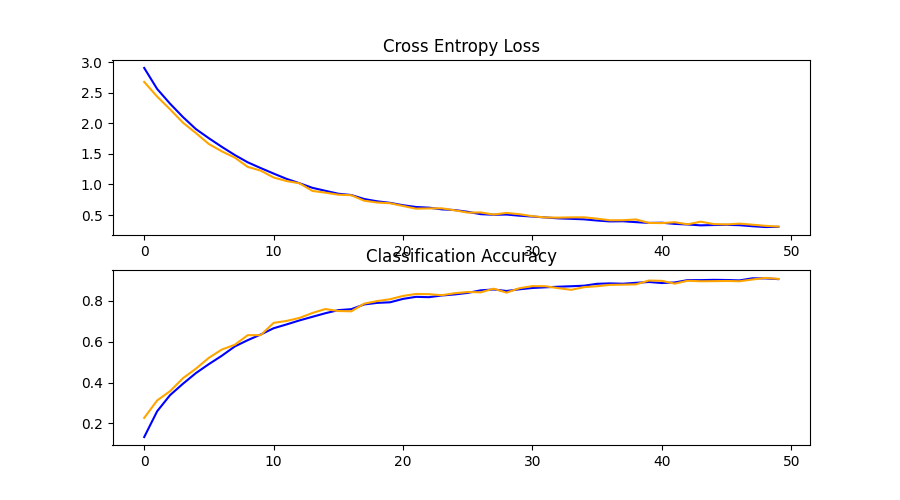

![modelV1confusionmatrix.png](obrazy/modelV1confusionmatrix.png)
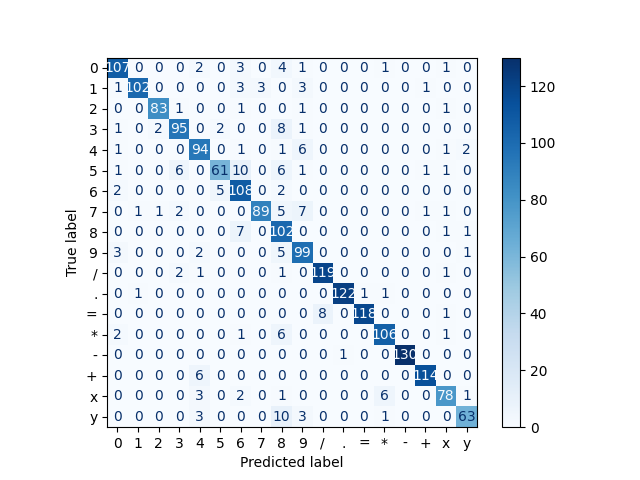

![modelV1missassignedImages.png](obrazy/modelV1missassignedImages.png)
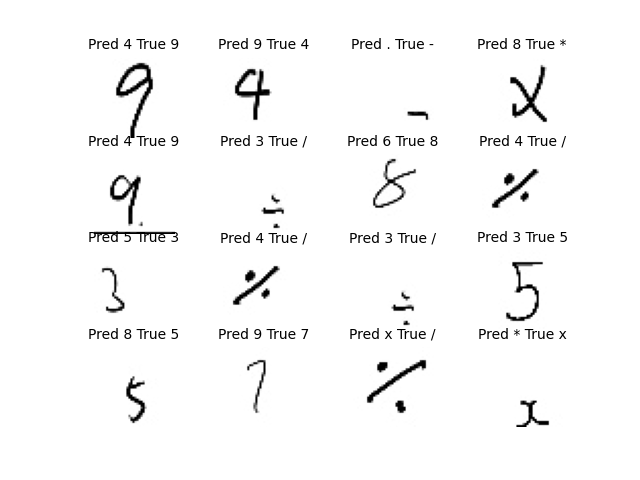

In [ ]:
from matplotlib import pyplot
from keras.models import Sequential, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

imgSize = 46

# define cnn model
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imgSize, imgSize, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten()) # w tym momencie mam obraz 4x4
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(18, activation='sigmoid'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# plot diagnostic learning curves
def summarize_diagnostics(history):
    pyplot.figure(figsize=(9,5))
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig("Projekt2/obrazy/modelV1creatingChanges.png")
    pyplot.close()


model = define_model()

# create data generator
datagen = ImageDataGenerator(
    rescale=1.0/255.0, # rescaling image values
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    )

# prepare iterators
train_it = datagen.flow_from_directory('Projekt2/data/train/',
    class_mode='categorical', batch_size=140, target_size=(imgSize, imgSize), color_mode='grayscale')
test_it = datagen.flow_from_directory('Projekt2/data/test/',
    class_mode='categorical', batch_size=140, target_size=(imgSize, imgSize), color_mode='grayscale')

# fit model
history = model.fit(train_it, steps_per_epoch=len(train_it),
    validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)

# evaluate model
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

# learning curves
summarize_diagnostics(history)

model.save('Projekt2/trainedModelV1')



# 3. Druga wersja modelu sieci neuronowej

Druga wersja modelu sieci neuronowej jest bardziej złożona i kożysta dodatkowo z warstw typu "Dropout" które zapobiegają przeuczeniu i pomagają w zwalczaniu szumów. Poprawność tego modelu wynosi **97.222%**.

![modelV2creatingChanges.png](obrazy/modelV2creatingChanges.png)
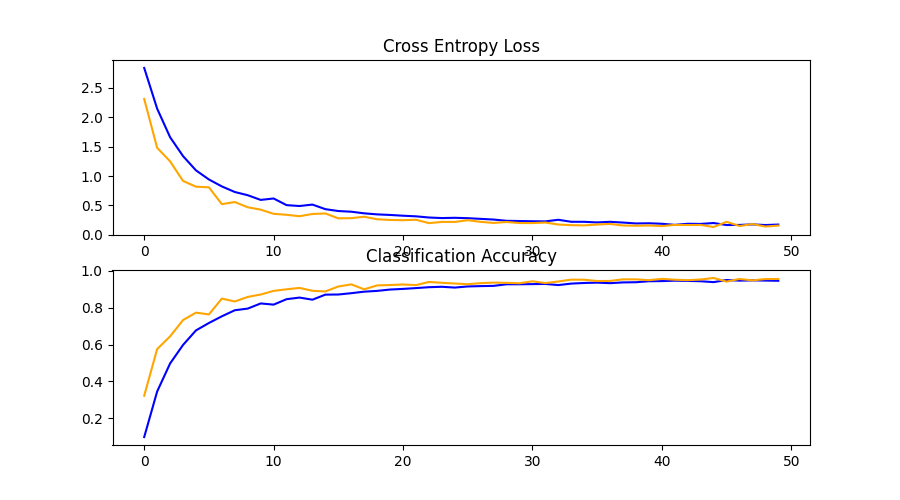

![modelV2confusionMatrix.png](obrazy/modelV2confusionMatrix.png)
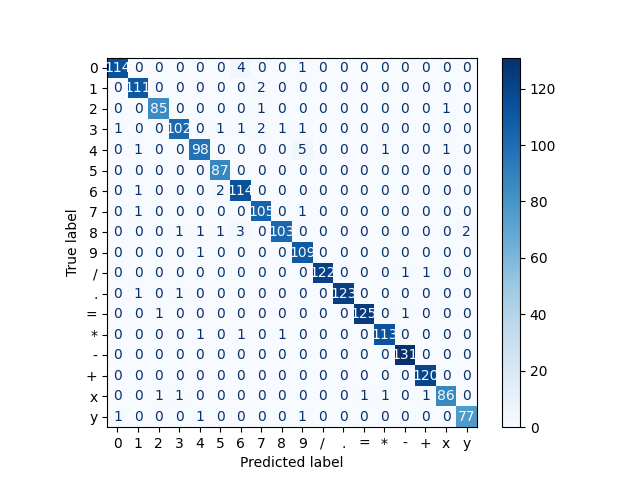

![modelV2missassignedImages.png](obrazy/modelV2missassignedImages.png)
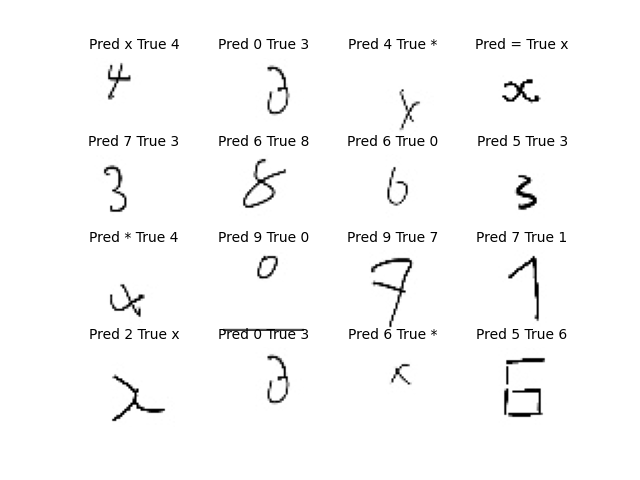

In [ ]:
def define_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25)) # zapobiega przeuczeniu i pomaga w zwalczaniu szumów (noise)
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(18, activation = "softmax"))
    # compile model
    optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. Pozostałe modele

Pozostałe trzy modele są analogiczne do pierwszej wersji modelu z tym że mają kolejno: jeden blok, dwa bloki i cztery bloki (blok się składa z warstwy konwolucyjnej 3x3 i warstwy typu max pooling 2x2), i mają kolejno: **45.556%**, **86.667%**, **94.949%** poprawności.

In [ ]:
# one block
def define_model_1():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imgSize, imgSize, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(18, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# two blocks
def define_model_2():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imgSize, imgSize, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(18, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

# four blocks
def define_model_4():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(imgSize, imgSize, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(18, activation='sigmoid'))
	# compile model
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

![modelOneBlockCreatingChanges.png](obrazy/modelOneBlockCreatingChanges.png)

![modelOneBlockConfusionMatrix.png](obrazy/modelOneBlockConfusionMatrix.png)

![modelTwoBlocksCreatingChanges.png](obrazy/modelTwoBlocksCreatingChanges.png)

![modelTwoBlocksConfusionMatrix.png](obrazy/modelTwoBlocksConfusionMatrix.png)

![modelFourBlocksCreatingChanges.png](obrazy/modelFourBlocksCreatingChanges.png)

![modelFourBlocksConfusionMatrix.png](obrazy/modelFourBlocksConfusionMatrix.png)

# 5. Porównanie modeli

| model                  | poprawność |
|------------------------|------------|
| Model jednoblokowy     | 45.556%    |
| Model dwublokowy       | 86.667%    |
| Model V1 (trzyblokowy) | 93.081%    |
| Model czteroblokowy    | 94.949%    |
| Model V2 (zawansowany) | 97.222%    |


![modelsComprasions.png](obrazy/modelsComprasions.png)